In [29]:
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
table = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
sp500_list = table[0]['Symbol'].to_list()
sp500_list = [s.replace('.', '-') for s in sp500_list]
len(sp500_list)

503

In [3]:
table = pd.read_html('https://en.wikipedia.org/wiki/Nasdaq-100')
nasdaq_list = table[4]['Ticker'].to_list()
nasdaq_list = [s.replace('.', '-') for s in nasdaq_list]
len(nasdaq_list)

102

In [4]:
stock_pool = list(set(sp500_list).union(set(nasdaq_list)))

In [5]:
from main import get_norm_return
norm_return = get_norm_return(stock_pool, '2020-01-01', '2020-12-31', dropna=True)

[*********************100%***********************]  526 of 526 completed

2 Failed downloads:
- CEG: Data doesn't exist for startDate = 1577854800, endDate = 1609390800
- OGN: Data doesn't exist for startDate = 1577854800, endDate = 1609390800


In [46]:
spy = yf.download("SPY", start="2020-01-01", end="2020-12-31")

[*********************100%***********************]  1 of 1 completed


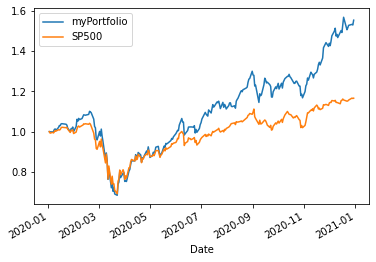

1.3262467499346524

In [55]:
from main import random_portfolio
p = random_portfolio(norm_return.columns)
# print(p[0], p[1])

initial_cap = 1e6
portfolio = norm_return[p[0]] * p[1] * initial_cap
portfolio['TotalPos'] = portfolio.sum(axis=1)
portfolio['PercentagePos'] = portfolio.TotalPos / portfolio.TotalPos.iloc[0]
portfolio['DailyPercentageReturn'] = portfolio['TotalPos'].pct_change(1)

portfolio.PercentagePos.plot(label='myPortfolio')

(spy['Adj Close'] / spy['Adj Close'].iloc[0]).plot(label='SP500')
plt.legend()
plt.show()

kvalue = {'D': np.sqrt(252), 'W': np.sqrt(52), 'M': np.sqrt(12)}
sharpe = kvalue['D'] * portfolio.DailyPercentageReturn.mean() / portfolio.DailyPercentageReturn.std()
sharpe

In [57]:
p[0], p[1]

(array(['ATVI', 'ACN', 'RMD', 'TSLA', 'LYB', 'REGN', 'LW', 'ANSS', 'STZ',
        'CMCSA', 'TJX', 'CCL', 'EMR', 'CAH', 'MOS', 'XRAY'], dtype=object),
 array([0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625,
        0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625]))